### Import Relevant Libraries

In [0]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.util import minibatch
from spacy.training import offsets_to_biluo_tags

import re 

from pyspark.sql.functions import col, explode, size, lower, split, monotonically_increasing_id
from pyspark.sql import Row
import random
import os

from functools import reduce

%pip install gensim
import gensim.downloader as api

%pip install sentence-transformers
from sentence_transformers import SentenceTransformer

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/78/4f/f6045d5d5f8e7838c42572607ce440f95dbf4de5da41ae664198c2839c05/gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/26.7 MB ? eta -:--:--
   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/26.7 MB 50.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/26.7 MB 128.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 16.2/26.7 MB 209.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 23.6/26.7 MB 212.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 26.7/26.7 MB 214.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 26.7/26.7 MB 214.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 26.7/26.7 MB 214.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 26.7/26.7 MB 214.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 26.7/26.7 

2025-03-29 14:50:20.151903: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-29 14:50:20.241884: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-29 14:50:20.619806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-29 14:50:24.623007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Preprocess data

In [0]:
def upload_data(file_location):
    # File location and type
    file_type = "csv"

    # CSV options
    infer_schema = "false"
    first_row_is_header = "true"
    delimiter = ","
    quote_char = '"'

    # The applied options are for CSV files. For other file types, these will be ignored.
    df = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .option("multiline", "true") \
    .option("quote", quote_char) \
    .option("maxCharsPerColumn", 1000000) \
    .option("escape", '"') \
    .load(file_location)

    return df

def preprocess_data(job_skills_df, job_description_df_list):

    combined_df = reduce(lambda df1, df2: df1.union(df2), job_description_df_list)

    df_joined = combined_df.join(job_skills_df, on="job_link", how="left")
    df_joined = df_joined.withColumn("job_skills", lower(col("job_skills"))).withColumn("job_summary", lower(col("job_summary")))


    return df_joined

Load Final df

In [0]:
job_skill_file_location = "/FileStore/tables/job_skills.csv"
job_summary_file_locations = [f"/FileStore/tables/job_description(bbr)/job_summary_part{i}.csv" for i in range(1, 4)]
job_skill_df = upload_data(job_skill_file_location)
job_summary_list = [upload_data(file_location) for file_location in job_summary_file_locations]

final_df = preprocess_data(job_skill_df, job_summary_list)
final_df = final_df.withColumn("skills_list", split(col("job_skills"), ", "))


In [0]:
final_df.count()

1297332

delete rows with empty labels

In [0]:
final_df = final_df.filter((col("skills_list").isNotNull()) | (size(col("skills_list")) > 0))

In [0]:
final_df.count()

1294374

In [0]:
final_df.display()

job_link job_summary job_skills skills_list https://au.linkedin.com/jobs/view/2x-senior-ccu-icu-rns-%245000-bonus-regional-nsw-at-curis-recruitment-3797851296 $5000 bonus available now!! don't miss this fantastic opportunity to work in outback nsw on a 12-week contract.
are you an experienced senior ccu/icu registered nurse looking for an adventure? we have a fantastic contract opportunity in outback nsw with a 12 week contract starting asap. join this amazing health service making a difference in regional nsw!
job details
$5000 bonus!!!
12 week contract
up to $57.23 per hour (based on experience) + 11% superannuation
free travel provided from within australia
fully paid for accommodation provided
start asap
the location
you will be living in an area with a population of approximately 19,000 people. the area is known for its thriving arts community, mining heritage and access to many outback adventures. the area also offers fantastic galleries, cafe's and a lot more, with plenty to do and explore in your time off. the town has an airport with daily flights to sydney, dubbo, adelaide, griffith and mildura making it easily accessible to get in and out easily.
to be eligible for this position, you must have the following:
current ahpra registration with no restrictions
senior rn experience in ccu/icu essential
must be ventilator and als competent
to apply for this great opportunity, please email an up-to-date copy of your cv to ellie@curis.com.au and we will be in contact within 24 hours.
why work with curis recruitment?
we have a proven record of placing nurses into fantastic positions across australia with some of the best hospitals and health centres.
our clients know that we only represent the best nurses out there so when you are represented by us you are always shown in the best light and this gives you a foot in the door right at that first step.
not the right role for you but know someone who would be amazing??? refer them to us and if we place them you are eligible for a $300 gift voucher of your choice! make sure they mention your name when they apply. feel free to check out our other vacancies at www.curisrecruitment.com.au
don’t miss your opportunity to earn an extra $5k!
show more
show less senior ccu/icu registered nurse, current ahpra registration with no restrictions, senior rn experience in ccu/icu, ventilator and als competent, australiabased List(senior ccu/icu registered nurse, current ahpra registration with no restrictions, senior rn experience in ccu/icu, ventilator and als competent, australiabased) https://au.linkedin.com/jobs/view/accident-management-specialist-at-imok-accident-replacement-cars-3791776244 company description
imok accident replacement cars provides like-for-like hire cars, claims management and repairs management services to not-at-fault accident drivers australia wide.
role description
this is a full-time on-site role for an accident management specialist located in sydney, nsw at imok accident replacement cars. the primary responsibility of the accident management specialist is to arrange hire cars, assess eligibility, investigate and determine the at-fault party, manage insurance claims, and manage repairs for the clients. the role also includes negotiating with insurance companies, working with lawyers and handling claim payments.
qualification and experience
some working knowledge of motor insurance policies and the auto industry i
n generalexper
ience as a motor insurance case manager is desirable but not essentialexcel
lent analytical and problem-solving skillsstron
g verbal and written communication skillsexcel
lent negotiation and customer service skillsabili
ty to work independently and in a team environment to meet deadlinesprofi
cient in microsoft office, including excel, word, and outlook, as well as claims processing software
show more
show less motor insurance policies, auto industry, motor insurance case manager, analytical, problemsolving, verbal communication, written co

## Train Models

#### Create sets

train set of 1000 rows 

In [0]:
sample1000_list = final_df.rdd.takeSample(False, 1000, seed=42)
sample1000_df = spark.createDataFrame(sample1000_list, schema=final_df.schema)

train set of 10000 rows

In [0]:
final_sub_1000_df = final_df.subtract(sample1000_df)
sample10000_list = final_sub_1000_df.rdd.takeSample(False, 10000, seed=42)
sample10000_df = spark.createDataFrame(sample10000_list, schema=final_df.schema)

train set of 20000 rows

In [0]:
final_sub_1000_10000_df = final_sub_1000_df.subtract(sample10000_df)
sample20000_list = final_sub_1000_10000_df.rdd.takeSample(False, 20000, seed=42)
sample20000_df = spark.createDataFrame(sample20000_list, schema=final_df.schema)

#### prepare for training

Load Word2Vec

In [0]:
WORD2VEC_PATH = 'word2vec.bin'
word2vec_model = api.load("word2vec-google-news-300")

[--------------------------------------------------] 0.1% 2.4/1662.8MB 

*** WARNING: max output size exceeded, skipping output. ***

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Load Glove

In [0]:
# Load GloVe model
GLOVE_MODEL = "glove-wiki-gigaword-300"
glove_model = api.load(GLOVE_MODEL)

# Load Spacy model
nlp = spacy.blank("en")

# Convert GloVe to SpaCy format
vector_data = {word: glove_model[word] for word in glove_model.index_to_key}

nlp.vocab.vectors = spacy.vectors.Vectors(
    data=np.vstack(list(vector_data.values())),
    keys=list(vector_data.keys()),
    name="glove"
)

[--------------------------------------------------

*** WARNING: max output size exceeded, skipping output. ***

[==================================================] 100.0% 376.1/376.1MB downloaded


prepare training data

In [0]:
def prepare_training_data(job_descriptions, skills_list, model='en'):
    """
    Converts job descriptions and known skills into SpaCy NER training format.
    Ensures no misaligned entities appear.
    """
    training_data = []
    nlp_model = spacy.blank(model)  # Initialize blank SpaCy model
    
    for job_desc, skills in zip(job_descriptions, skills_list):
        if skills is None:
            continue 
        entities = []
        seen_spans = set()  # Track (start, end) spans to avoid duplicates
        
        for skill in skills:
            skill = skill.strip()  # Remove extra spaces
            pattern = r'\b' + re.escape(skill) + r'\b'  # Exact word boundary match
            
            for match in re.finditer(pattern, job_desc, flags=re.IGNORECASE):
                start, end = match.start(), match.end()
                
                # Ensure skill matches exactly and isn't part of another word
                if job_desc[start:end].strip() == skill and (start, end) not in seen_spans:
                    entities.append((start, end, "SKILL"))
                    seen_spans.add((start, end))
        
        # Sort entities by start position to check for overlaps
        entities = sorted(entities, key=lambda x: x[0])
        non_overlapping_entities = []
        last_end = -1
        
        for start, end, label in entities:
            if start >= last_end:
                non_overlapping_entities.append((start, end, label))
                last_end = end
        
        #  Verify Alignment Before Adding to Training Data
        doc = nlp_model.make_doc(job_desc)  #  Use the correct SpaCy method
        biluo_tags = offsets_to_biluo_tags(doc, non_overlapping_entities)
        if "-" not in biluo_tags:  # Only keep correctly aligned entities
            training_data.append((job_desc, {"entities": non_overlapping_entities}))
        else:
            print(f" Skipped misaligned entity in: {job_desc[:100]}...")

    return training_data

prepare 1000

In [0]:
job_descriptions = sample1000_df.select("job_summary").rdd.flatMap(lambda x: x).collect()
skills_list = sample1000_df.select("skills_list").rdd.flatMap(lambda x: x).collect()
spacy_training1000_data = prepare_training_data(job_descriptions, skills_list, 'en')

prepare 10000

In [0]:
job_descriptions_10000 = sample10000_df.select("job_summary").rdd.flatMap(lambda x: x).collect()
skills_list_10000 = sample10000_df.select("skills_list").rdd.flatMap(lambda x: x).collect()
spacy_training10000_w2v = prepare_training_data(job_descriptions_10000, skills_list_10000, 'en')

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

prepare 20000

In [0]:


job_descriptions_20000 = sample20000_df.select("job_summary").rdd.flatMap(lambda x: x).collect()
skills_list_20000 = sample20000_df.select("skills_list").rdd.flatMap(lambda x: x).collect()
spacy_training20000_w2v = prepare_training_data(job_descriptions_20000, skills_list_20000, 'en')


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:445)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:528)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:633)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:656)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:276)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

#### Training 

training ner - 1000 set 

In [0]:
nlp = spacy.blank("en")

#  Add NER Pipeline 
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

#  Add Labels to NER
for _, annotations in spacy_training1000_data:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])  # "SKILL" entity

#  Convert Data to SpaCy Examples
examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in spacy_training1000_data]

optimizer = nlp.initialize()

#  Training loop
for epoch in range(30):  
    random.shuffle(examples)
    losses = {}
    
    for batch in spacy.util.minibatch(examples, size=8):
        nlp.update(batch, sgd=optimizer, drop=0.3, losses=losses)
    
    print(f"Epoch {epoch + 1} Loss: {losses}")

#  Save Model
nlp.to_disk("ner_model_1000")
print(" NER Model Training Completed!")

prepare ner Glove 1000

In [0]:
nlp = spacy.blank("en")

# Convert GloVe to SpaCy format
vector_data = {word: glove_model[word] for word in glove_model.index_to_key}

nlp.vocab.vectors = spacy.vectors.Vectors(
    data=np.vstack(list(vector_data.values())),
    keys=list(vector_data.keys()),
    name="glove"
)

training ner - 1000 glove

In [0]:
#  Add NER Pipeline
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

#  Add Labels to NER
for _, annotations in spacy_training1000_data:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])  # "SKILL" entity

#  Convert Data to SpaCy Examples
examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in spacy_training1000_data]

#  Initialize Model
optimizer = nlp.initialize()

#  Training loop
for epoch in range(30): 
    random.shuffle(examples)
    losses = {}
    
    for batch in spacy.util.minibatch(examples, size=8): 
        nlp.update(batch, sgd=optimizer, drop=0.3, losses=losses)
    
    print(f"Epoch {epoch + 1} Loss: {losses}")

# Save Model
nlp.to_disk("/dbfs/ner_model_1000_glove")
print(" NER Model Training Completed!")

prepare ner Word2vec 1000

In [0]:
nlp_w2v_1000 = spacy.blank("en")

vector_data = {}
for word in word2vec_model.index_to_key:
    if word in word2vec_model:
        vector_data[word] = word2vec_model[word]

nlp_w2v_1000.vocab.vectors = spacy.vectors.Vectors(
    data=np.vstack([vector_data[word] for word in vector_data]),
    keys=list(vector_data.keys()),
    name="word2vec"
    )

training ner - 1000 Word2vec

In [0]:
#  Add NER Pipeline
if "ner" not in nlp_w2v_1000.pipe_names:
    ner = nlp_w2v_1000.add_pipe("ner", last=True)
else:
    ner = nlp_w2v_1000.get_pipe("ner")

#  Add Labels to NER
for _, annotations in spacy_training1000_data:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])  # "SKILL" entity

#  Convert Data to SpaCy Examples
examples = [Example.from_dict(nlp_w2v_1000.make_doc(text), annotations) for text, annotations in spacy_training1000_data]

#  Initialize Model
optimizer = nlp_w2v_1000.initialize()

#  Training loop
for epoch in range(30): 
    random.shuffle(examples)
    losses = {}
    
    for batch in spacy.util.minibatch(examples, size=8): 
        nlp_w2v_1000.update(batch, sgd=optimizer, drop=0.3, losses=losses)
    
    print(f"Epoch {epoch + 1} Loss: {losses}")

#  Save Model
nlp.to_disk("ner_model_1000_word2vec")
print(" NER Model Training Completed!")

prepare ner Word2vec 10000

In [0]:
nlp_w2v_10000 = spacy.blank("en")

vector_data = {}
for word in word2vec_model.index_to_key:
    if word in word2vec_model:
        vector_data[word] = word2vec_model[word]

nlp_w2v_10000.vocab.vectors = spacy.vectors.Vectors(
    data=np.vstack([vector_data[word] for word in vector_data]),
    keys=list(vector_data.keys()),
    name="word2vec"
    )

training ner - 10000 Word2vec

In [0]:
#  Add NER Pipeline 
if "ner" not in nlp_w2v_10000.pipe_names:
    ner = nlp_w2v_10000.add_pipe("ner", last=True)
else:
    ner = nlp_w2v_10000.get_pipe("ner")

#  Add Labels to NER
for _, annotations in spacy_training10000_w2v:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])  # "SKILL" entity

#  Convert Data to SpaCy Examples
examples = [Example.from_dict(nlp_w2v_10000.make_doc(text), annotations) for text, annotations in spacy_training10000_w2v]

#  Initialize Model 
optimizer = nlp_w2v_10000.initialize()

#  Training loop
for epoch in range(30):  
    random.shuffle(examples)
    losses = {}
    
    for batch in spacy.util.minibatch(examples, size=8):  
        nlp_w2v_10000.update(batch, sgd=optimizer, drop=0.3, losses=losses)
    
    print(f"Epoch {epoch + 1} Loss: {losses}")

#  Save Model
nlp_w2v_10000.to_disk("ner_model_10000_word2vec")
print(" NER Model Training Completed!")

In [0]:
nlp_w2v_10000.to_disk("/dbfs/ner_model_10000_word2vec")

training ner - 20000

In [0]:

nlp = spacy.blank("en")

# Add NER Pipeline 
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

#  Add Labels to NER
for _, annotations in spacy_training_data:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])  # "SKILL" entity

#  Convert Data to SpaCy Examples
examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in spacy_training_data]

#  Initialize Model 
optimizer = nlp.initialize()

#  Training loop
for epoch in range(30):  
    random.shuffle(examples)
    losses = {}
    
    for batch in spacy.util.minibatch(examples, size=8):  
        nlp.update(batch, sgd=optimizer, drop=0.3, losses=losses)
    
    print(f"Epoch {epoch + 1} Loss: {losses}")

#  Save Model
nlp.to_disk("ner_model_20000")
print(" NER Model Training Completed!")

prepare ner Word2vec 20000

In [0]:
nlp_w2v_20000 = spacy.blank("en")

vector_data = {}
for word in word2vec_model.index_to_key:
    if word in word2vec_model:
        vector_data[word] = word2vec_model[word]

nlp_w2v_20000.vocab.vectors = spacy.vectors.Vectors(
    data=np.vstack([vector_data[word] for word in vector_data]),
    keys=list(vector_data.keys()),
    name="word2vec"
    )

training ner - 20000 Word2vec

In [0]:
#  Add NER Pipeline
if "ner" not in nlp_w2v_20000.pipe_names:
    ner = nlp_w2v_20000.add_pipe("ner", last=True)
else:
    ner = nlp_w2v_20000.get_pipe("ner")

#  Add Labels to NER
for _, annotations in spacy_training20000_w2v:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])  # "SKILL" entity

#  Convert Data to SpaCy Examples
examples = [Example.from_dict(nlp_w2v_20000.make_doc(text), annotations) for text, annotations in spacy_training20000_w2v]

#  Initialize Model 
optimizer = nlp_w2v_20000.initialize()

#  Training loop
for epoch in range(30):  
    random.shuffle(examples)
    losses = {}
    
    for batch in spacy.util.minibatch(examples, size=4):  
        nlp_w2v_20000.update(batch, sgd=optimizer, drop=0.3, losses=losses)
    
    print(f"Epoch {epoch + 1} Loss: {losses}")

print(" NER Model Training Completed!")

In [0]:
#  Save Model
nlp_w2v_20000.to_disk("/dbfs/ner_model_20000_word2vec")

####Fine tuning model of 10000 rows with word2vec using our scraped data of glassdoor

Load scraped glassdoor df

In [0]:
path_glassdoor_file = "/FileStore/tables/job_description(bbr)/jobs_glassdoor_final.csv"
glassdoor_df = upload_data(path_glassdoor_file)
glassdoor_df.display()

Job Info Cookie Crew: As a member of the Cookie Crew at our Grand Rapids store located at 44 Ionia Avenue SW Grand Rapids , MI 49503 , you are the ultimate Insomniac. Not only are you the point person at the front of the store for interacting with our customers, but you also get to bake all of our awesome Warm and Delicious cookies as well! SOME OF OUR SWEET PERKS: Flexible part-time work schedules Free cookies & Employee Discount Paid Time Off Excellent training Job stability with a rapidly growing and reputable company Achievable growth/promotion opportunities You get to work in a fun, exciting team environment WHAT ELSE WILL I DO AS A MEMBER OF THE COOKIE CREW? Promptly greet guests entering the store and take their orders according to procedure Help customers understand menu items, answer clarifying questions, and repeat orders for accuracy Give each customer a warm experience with a smile in person & over the phone Bake our delicious cookies to perfection & a scoop of ice cream Ensure fast, warm, and correct delivery orders are packaged and sent out Handle cash and payments accurately and have no shortages or overages Cleaning, sanitizing, and maintaining the bakery DESIRED SKILLS/EXPERIENCE: Prior experience in a customer service focused role - preferred Personable, genuine, outgoing demeanor Ambitious nature Great communication and organizational skills Must be 18 years or older to be employed Must be able to work nights, weekends and holidays Legally eligible to work in the United States About us: Insomnia Cookies was founded in a college dorm room by then-student, Seth Berkowitz. Fast forward 20 years and so... many....cookies... later, our innovative bakery + delivery concept has become a cult brand known for its rabid following of cookie lovers who crave Insomnia’s warm, delicious delivery all day and late into the night. With an expanding footprint of over 300 stores globally, an experiential, “sweet-easy” concept as the brand’s flagship in Philadelphia, Pa. (where Insomnia Cookies is headquartered), and a rapidly-growing nationwide shipping and gifting portfolio... Insomnia Cookies is revolutionizing the cookie game by truly " Imagining What’s Possible "! Bike Delivery Driver: As a Bike Delivery Driver at our Penn Quarter store located at 614 E. Street NW Washington, DC 20001, you are our “Boots on the ground!”, and the main face that our Insomniacs see outside of the bakery! You give the word “Delivery” a whole new meaning by delivering the Cookie Magic to our fans wherever they are. OUR DELIVERY DRIVER PERKS, COMP & SCHEDULE: Compensation: Guaranteed $17.00/hr minimum – up to $22.00/hr in earnings. Schedule: Potential to work up to 30+ hours per week Pay on Demand (why wait until the end of the week…get paid your earned wages at the end of the day!) Small but busy delivery zones Paid vacation and sick time off Flexible part-time work schedules Pet insurance for your furry loved ones Job stability with a rapidly growing and reputable company Achievable growth/promotion opportunities FREE cookies with every shift! WHAT WILL I DO AS A DELIVERY DRIVER? Check orders for quality and accuracy before they leave the store. Deliver our cookies, milk and ice cream to our loyal fan base, in a timely and safe fashion. Provide quality customer service through positive and professional interaction with customers whether in-person or by phone. Use Insomnia’s delivery app to approved company standards and provide accurate status updates to customers. DESIRED SKILLS/EXPERIENCE: Excellent time management and organizational skills Knowledge of the 2-mile radius surrounding the store is a plus! Must have your own vehicle in working order and have current insurance for that vehicle Must have a smartphone with data plan Must be legally eligible to work in the United States Must be 18 years or older to be employed About us: Insomnia Cookies was founded in a college dorm room by then-student, Seth Berkowitz. Fast forward 20 years and so

Load our model to tag glassdoor df 

In [0]:
nlp_ner_10000_word2vec = spacy.load("ner_model_10000_word2vec")

In [0]:
glassdoor_list = glassdoor_df.collect()
print(len(glassdoor_list))

In [0]:
skills_pred_10000_word2vec_glassdoor = []

for job in glassdoor_list:
    doc_10000_word2vec_glassdoor = nlp_ner_10000_word2vec(job[0])
    skills_extracted_10000_word2vec_glassdoor = [ent.text for ent in doc_10000_word2vec_glassdoor.ents if ent.label_ == "SKILL"]
    skills_pred_10000_word2vec_glassdoor.append(set(skills_extracted_10000_word2vec_glassdoor))

In [0]:
# Convert Python list of lists to Spark DataFrame
skills_rows = [Row(skills_list=list(skills)) for skills in skills_pred_10000_word2vec_glassdoor]
skills_df = spark.createDataFrame(skills_rows)

# Add index to both DataFrames to align them
glassdoor_df_indexed = glassdoor_df.withColumn("idx", monotonically_increasing_id())
skills_df_indexed = skills_df.withColumn("idx", monotonically_increasing_id())

# Join on index
glassdoor_df_with_skills = glassdoor_df_indexed.join(skills_df_indexed, on="idx", how="inner").drop("idx")


In [0]:
glassdoor_df_with_skills = glassdoor_df_with_skills.filter((size(col("skills_list")) > 0))
print(glassdoor_df_with_skills.count())

In [0]:
glassdoor_df_with_skills.display()

Prepare glassdoor df 

In [0]:
job_descriptions_galssdoor = glassdoor_df_with_skills.select("Job Info").rdd.flatMap(lambda x: x).collect()
skills_list_glassdoor = glassdoor_df_with_skills.select("skills_list").rdd.flatMap(lambda x: x).collect()
spacy_glassdoor_data = prepare_training_data(job_descriptions_galssdoor, skills_list_glassdoor, 'en')

Fine tune the ner 10000 word2vec with our glassdoor tagged data

In [0]:
# Get or add the NER pipeline
if "ner" not in nlp_ner_10000_word2vec.pipe_names:
    ner = nlp_ner_10000_word2vec.add_pipe("ner", last=True)
else:
    ner = nlp_ner_10000_word2vec.get_pipe("ner")

#  Add labels
for _, annotations in spacy_glassdoor_data:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])

#  Convert training data to SpaCy Examples
examples = [Example.from_dict(nlp_ner_10000_word2vec.make_doc(text), annotations) for text, annotations in spacy_glassdoor_data]

# Resume training loop
optimizer = nlp_ner_10000_word2vec.resume_training()
for epoch in range(30):
    random.shuffle(examples)
    losses = {}
    for example in examples:
        nlp_ner_10000_word2vec.update([example], losses=losses, drop=0.3)
    print(f"Epoch {epoch+1} Loss: {losses['ner']:.4f}")

# Save updated model
nlp_ner_10000_word2vec.to_disk("ner_10000_word2vec_glassdoor")

create validation and test sets

In [0]:
# Remove rows in sample_df_1000, sample_df_10000 and sample_df_20000 from final_df

print(f"final DF Count: {final_df.count()}")
remaining_df = final_df.subtract(sample1000_df)
print(f"Remaining DF Count after subtraction 1000: {remaining_df.count()}")
remaining_df = remaining_df.subtract(sample10000_df)
print(f"Remaining DF Count after subtraction 10000: {remaining_df.count()}")
remaining_df = remaining_df.subtract(sample20000_df)
print(f"Remaining DF Count after subtraction 20000: {remaining_df.count()}")



final DF Count: 1294374
Remaining DF Count after subtraction 1000: 1293374
Remaining DF Count after subtraction 10000: 1283374
Remaining DF Count after subtraction 20000: 1263374


In [0]:
# create validation set from remaining df 
validate_list = remaining_df.rdd.takeSample(False, 2000, seed=42)
validate_df = spark.createDataFrame(validate_list, schema=final_df.schema)

remaining_df_after_val = remaining_df.subtract(validate_df)
print(f"Remaining DF Count after validation: {remaining_df_after_val.count()}")

# create test set from remaining df (after validation subtraction)
test_list = remaining_df_after_val.rdd.takeSample(False, 2000, seed=42)
test_df = spark.createDataFrame(test_list, schema=final_df.schema)

Remaining DF Count after validation: 1261374


Load all the models

In [0]:
# Load Trained Models
import spacy
nlp_ner_1000 = spacy.load("ner_model_1000")
nlp_ner_1000_glove = spacy.load("ner_model_1000_glove")
nlp_ner_1000_word2vec = spacy.load("ner_model_1000_word2vec")
nlp_ner_10000_word2vec = spacy.load("ner_model_10000_word2vec")
nlp_ner_20000 = spacy.load("ner_model_20000")
nlp_ner_10000_glassdoor = spacy.load("ner_10000_word2vec_glassdoor")

Run all models on validation set

In [0]:
# test models on validation set

skills_pred_20000 = []
skills_pred_1000 = []
skills_pred_1000_word2vec = []
skills_pred_10000_word2vec = []
skills_pred_1000_glove = []
skills_pred_10000_glassdoor = []


for job in validate_list:
    
    doc_20000 = nlp_ner_20000(job[1])
    doc_1000 = nlp_ner_1000(job[1])
    doc_1000_word2vec = nlp_ner_1000_word2vec(job[1])
    doc_10000_word2vec = nlp_ner_10000_word2vec(job[1])
    doc_1000_glove = nlp_ner_1000_glove(job[1])
    doc_10000_glassdoor = nlp_ner_10000_glassdoor(job[1])

    skills_extracted_20000 = [ent.text for ent in doc_20000.ents if ent.label_ == "SKILL"]
    skills_extracted_1000 = [ent.text for ent in doc_1000.ents if ent.label_ == "SKILL"]
    skills_extracted_1000_word2vec = [ent.text for ent in doc_1000_word2vec.ents if ent.label_ == "SKILL"]
    skills_extracted_10000_word2vec = [ent.text for ent in doc_10000_word2vec.ents if ent.label_ == "SKILL"]
    skills_extracted_1000_glove = [ent.text for ent in doc_1000_glove.ents if ent.label_ == "SKILL"]
    skills_extracted_10000_glassdoor = [ent.text for ent in doc_10000_glassdoor.ents if ent.label_ == "SKILL"]
    
    skills_pred_20000.append(set(skills_extracted_20000))
    skills_pred_1000.append(set(skills_extracted_1000))
    skills_pred_1000_word2vec.append(set(skills_extracted_1000_word2vec))
    skills_pred_10000_word2vec.append(set(skills_extracted_10000_word2vec))
    skills_pred_1000_glove.append(set(skills_extracted_1000_glove))
    skills_pred_10000_glassdoor.append(set(skills_extracted_10000_glassdoor))

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

Test on specific job description

In [0]:
text = "Geospatial Analyst: Job Description Bachelor’s degree in Geography, GIS, Engineering, or related field 6 Years of experience with lidar sensors and lidar classification and DEM creation Working knowledge of topo-bathy lidar sensors, including sensor hardware, operation, maintenance, flight planning, and processing Thorough understanding of geospatial projections and ellipsoid/geoid elevation data Must be able to obtain and maintain a DoD TS/SCI security clearance Strong written and verbal communication skills Responsibilities Support development of new data acquisition and processing procedures Investigate and identify new and emerging technologies Support process improvement, automation, and machine learning initiatives and practices to advance data processing and analytics Work on complex projects with no supervision Support digital modernization initiatives , About Solis Applied Science Solis Applied Science (Solis), a Service-Disabled Veteran-Owned Small Business, was founded in 2016 by remote sensing experts, with deep-rooted academic, federal, military, and industry applied science backgrounds. From the onset, the focus of Solis has been to develop critical customer capabilities and apply novel technologies to problems across the remote sensing continuum. The result is a distinct appreciation of how remote sensing technologies can influence real-world situations and a genuine desire to assist our customers in adapting to an ever-changing, technology-driven environment. Our innovative, common-sense solutions solve the most complex problems our customers face and maximize return on their technology investments."

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:445)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:528)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:633)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:656)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:276)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
doc_10000_word2vec_text = nlp_ner_10000_word2vec(text)
doc_20000_text = nlp_ner_20000(text)
doc_1000_text = nlp_ner_1000(text)
doc_1000_word2vec_text = nlp_ner_1000_word2vec(text)
doc_1000_glove_text = nlp_ner_1000_glove(text)
doc_10000_glassdoor_text = nlp_ner_10000_glassdoor(text)

skills_10000_word2vec_text  = [ent.text for ent in doc_10000_word2vec_text.ents if ent.label_ == "SKILL"]
skills_20000_text  = [ent.text for ent in doc_20000_text.ents if ent.label_ == "SKILL"]
skills_1000_text  = [ent.text for ent in doc_1000_text.ents if ent.label_ == "SKILL"]
skills_1000_word2vec_text = [ent.text for ent in doc_1000_word2vec_text.ents if ent.label_ == "SKILL"]
skills_1000_glove_text = [ent.text for ent in doc_1000_glove_text.ents if ent.label_ == "SKILL"]
skills_10000_glassdoor_text = [ent.text for ent in doc_10000_glassdoor_text.ents if ent.label_ == "SKILL"]


print("try 10000 glassdoor text:\n")
print(set(skills_10000_glassdoor_text))
print("---------------------\n")

print("try 20000 text:\n")
print(set(skills_20000_text))
print("---------------------\n")

print("try 10000 word2vec text:\n")
print(set(skills_10000_word2vec_text))
print("---------------------\n")
      
print("try 1000 with word2vec text:\n")
print(set(skills_1000_word2vec_text))
print("---------------------\n")

print("try 1000 with glove text:\n")
print(set(skills_1000_glove_text))
print("---------------------\n")

print("try 1000 text:\n")
print(set(skills_1000_text))

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:445)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:528)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:633)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:656)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:276)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

### Evaluation :

evaluate with jaccard and f1 scores

In [0]:
def jaccard_precision_score(true_skills_df, predicted_labels, model_name):
    """
    Evaluates the NER model using Jaccard similarity.
    
    Args:
    - test_df: Spark DataFrame containing the test set (must have "skills_list" column as true labels)
    - predicted_labels: List of sets containing extracted skills per job description
    
    Returns:
    - A dictionary with Jaccard Similarity Score
    """
    jaccard_scores = []
    adjusted_scores = []
    true_set = true_skills_df.collect()

    f1_scores = []
    precision_scores = []
    recall_scores = []

    for idx, row in enumerate(true_set):
        true_skills = set([s.lower() for s in row["skills_list"]])  # Convert to lowercase
        predicted_skills = set([s.lower() for s in predicted_labels[idx]])  # Lowercase predicted
        
        #  Compute Jaccard Similarity
        intersection = len(true_skills & predicted_skills)
        union = len(true_skills | predicted_skills)
        score = intersection / union if union > 0 else 0
        jaccard_scores.append(score)

        # compute evaluation scores like Precision, Recall and F1
        tp = len(true_skills & predicted_skills)
        fp = len(predicted_skills - true_skills)
        fn = len(true_skills - predicted_skills)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
   
    # Compute Average Jaccard Score
    avg_jaccard = np.mean(jaccard_scores) if jaccard_scores else 0.0

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    
    print(f"\n Evaluation Metrics of {model_name}:")
    print(f" Jaccard Similarity Score: {avg_jaccard:.4f}")
    print(f" Precision: {avg_precision:.4f}")
    print(f" Recall:    {avg_recall:.4f}")
    print(f" F1 Score:  {avg_f1:.4f}")
    
    return jaccard_scores, avg_jaccard, avg_precision


evaluate with semantic embedding (miniLM)

In [0]:
# Load pre-trained sentence transformer model
minilm_model = SentenceTransformer('all-MiniLM-L6-v2')

/databricks/python/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [0]:
def semantic_similarity_score(true_skills_df, predicted_labels, sentence_tranformer, model_name):
    """
    Evaluate predicted skills using sentence embedding similarity.
    
    Args:
    - true_skills_df: Spark DataFrame with "skills_list" column (ground truth)
    - predicted_labels: List of sets/lists of predicted skills
    - model_name: Name of the model for display
    
    Returns:
    - List of cosine similarity scores between true and predicted skill sentences
    """
    similarity_scores = []
    true_rows = true_skills_df.collect()
    
    for idx, row in enumerate(true_rows):
        true_skills = " ".join([s.lower().strip().replace("_", " ") for s in row["skills_list"]])
        predicted_skills = " ".join([s.lower().strip().replace("_", " ") for s in predicted_labels[idx]])
        
        # Generate embeddings
        embeddings = sentence_tranformer.encode([true_skills, predicted_skills])
        score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        similarity_scores.append(score)
    
    avg_similarity = np.mean(similarity_scores) if similarity_scores else 0.0

    print(f"\n Semantic Evaluation of {model_name}:")
    print(f" Average Cosine Similarity: {avg_similarity:.4f}")
    
    return similarity_scores, avg_similarity

evluate soft jaccard embedding 

In [0]:
def get_avg_vector(skill, model):
    words = skill.lower().split()
    vectors = [model[word] for word in words if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return None

In [0]:
def soft_jaccard_score(true_skills_df, predicted_labels, embedding_model, model_name, threshold = 0.7):
    """
    Compute soft Jaccard similarity using Word2Vec: match predicted and true skills by cosine similarity of individual skill embeddings.

    Args:
        true_skills_df (Spark DataFrame): must contain a 'skills_list' column (ground truth).
        predicted_labels (List[List[str]]): predicted skills for each job description.
        word2vec_model: Pretrained gensim Word2Vec model (e.g., Google News 300).
        threshold (float): Cosine similarity threshold for soft match.
        model_name (str): Label for printing results.

    Returns:
        scores (List[float]): Soft Jaccard scores for each row.
        avg_score (float): Mean soft Jaccard score.
    """
    
    soft_jaccard_scores = []
    rows = true_skills_df.collect()

    for idx, row in enumerate(rows):
        # Convert true skills to lowercase
        true_skills = set([s.lower() for s in row[3]])
        
        # Convert predicted skills to lowercase
        pred_skills = set([s.lower() for s in predicted_labels[idx]])
            
        if not true_skills and not pred_skills:
            soft_jaccard_scores.append(1.0)
            continue
        if not true_skills or not pred_skills:
            soft_jaccard_scores.append(0.0)
            continue

        
        matched_pred = 0

        for pred_idx, pred_skill in enumerate(pred_skills):
            if len(pred_skill.split(" ")) > 1:
                avg_pred = get_avg_vector(pred_skill, embedding_model)
                if avg_pred is not None:
                    pred_vec = get_avg_vector(pred_skill, embedding_model)
            elif pred_skill in embedding_model:
                pred_vec = embedding_model[pred_skill]
            else:
                continue

            for true_skill in true_skills:
                if len(true_skill.split(" ")) > 1:
                    avg_true = get_avg_vector(true_skill, embedding_model)
                    if avg_true is not None:
                        true_vec = get_avg_vector(true_skill, embedding_model)
                elif true_skill in embedding_model:
                    true_vec = embedding_model[true_skill]
                else:
                    continue

                sim = cosine_similarity([pred_vec], [true_vec])[0][0]
                if sim >= threshold:
                    matched_pred += 1

        intersection = matched_pred
        union = len(true_skills | pred_skills)

        score = intersection / union if union > 0 else 0
        soft_jaccard_scores.append(score)

    avg_score = np.mean(soft_jaccard_scores)
    print(f"\n Soft Jaccard (word2vec) for {model_name}: {avg_score:.4f}")
    return soft_jaccard_scores, avg_score

Print output for all the evaluation functions

In [0]:
# all evaluations for model trained with 1000 rows
jaccard_precision_1000 = jaccard_precision_score(validate_df, skills_pred_1000,"model 1000")
semantic_score_1000 = semantic_similarity_score(validate_df, skills_pred_1000, minilm_model,"model 1000")
soft_score_1000 = soft_jaccard_score(validate_df, skills_pred_1000,word2vec_model,"model 1000")
print("-"*50)

# all evaluations for model trained with 1000 rows word2vec
jaccard_precision_1000_w2v = jaccard_precision_score(validate_df, skills_pred_1000_word2vec,"model 1000 word2vec")
semantic_score_1000_w2v = semantic_similarity_score(validate_df, skills_pred_1000_word2vec, minilm_model,"model 1000 word2vec")
soft_score_1000_w2v = soft_jaccard_score(validate_df, skills_pred_1000_word2vec,word2vec_model,"model 1000 word word2vec")
print("-"*50)

# all evaluations for model trained with 1000 rows glove
jaccard_precision_1000_glove = jaccard_precision_score(validate_df, skills_pred_1000_glove, "model 1000 glove")
semantic_score_1000_glove = semantic_similarity_score(validate_df, skills_pred_1000_glove, minilm_model,"model 1000 glove")
soft_score_1000_glove = soft_jaccard_score(validate_df, skills_pred_1000_glove,word2vec_model,"model 1000 glove")
print("-"*50)

# all evaluations for model trained with 10000 rows with word2vec
jaccard_precision_10000_w2v = jaccard_precision_score(validate_df, skills_pred_10000_word2vec, "model 10000 word2vec")
semantic_score_10000_w2v = semantic_similarity_score(validate_df, skills_pred_10000_word2vec, minilm_model,"model 10000 word2vec")
soft_score_10000_w2v = soft_jaccard_score(validate_df, skills_pred_10000_word2vec,word2vec_model,"model 10000 word2vec")
print("-"*50)

# all evaluations for model trained with 20000 rows 
jaccard_precision_20000 = jaccard_precision_score(validate_df, skills_pred_20000, "model 20000")
semantic_score_20000 = semantic_similarity_score(validate_df, skills_pred_20000, minilm_model,"model 20000")
soft_score_20000 = soft_jaccard_score(validate_df, skills_pred_20000,word2vec_model,"model 20000")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:445)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:528)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:633)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:656)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:276)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
models_name = ["model 1000", "model 1000 glove", "model 1000 word2vec", "model 10000 word2vec", "model 20000"]

jaccard_scores = [jaccard_precision_1000[1],
                  jaccard_precision_1000_glove[1],
                  jaccard_precision_1000_w2v[1],
                  jaccard_precision_10000_w2v[1],
                  jaccard_precision_20000[1]]

jaccard_list = [jaccard_precision_1000[0],
                jaccard_precision_1000_glove[0],
                jaccard_precision_1000_w2v[0],
                jaccard_precision_10000_w2v[0],
                #jaccard_precision_10000_glassdoor[0],
                jaccard_precision_20000[0]]
                  
precision_scores = [jaccard_precision_1000[2],
                    jaccard_precision_1000_glove[2],                  
                    jaccard_precision_1000_w2v[2],                  
                    jaccard_precision_10000_w2v[2],                
                    jaccard_precision_20000[2]]                  

semantic_scores = [semantic_score_1000[1],
                   semantic_score_1000_glove[1],
                   semantic_score_1000_w2v[1], 
                   semantic_score_10000_w2v[1],
                   semantic_score_20000[1]]  

semantic_list = [semantic_score_1000[0],
                 semantic_score_1000_glove[0],
                 semantic_score_1000_w2v[0],
                 semantic_score_10000_w2v[0],
                 semantic_score_20000[0]]

soft_jaccard_scores = [soft_score_1000[1],
                       soft_score_1000_glove[1],
                       soft_score_1000_w2v[1],
                       soft_score_10000_w2v[1],
                       soft_score_20000[1]]

soft_list = [soft_score_1000[0],
             soft_score_1000_glove[0],
             soft_score_1000_w2v[0],
             soft_score_10000_w2v[0],
             soft_score_20000[0]]

jaccard_semantic_soft_list = [jaccard_precision_1000[0]+semantic_score_1000[0]+soft_score_1000[0],
                              jaccard_precision_1000_glove[0]+semantic_score_1000_glove[0]+soft_score_1000_glove[0],
                              jaccard_precision_1000_w2v[0]+semantic_score_1000_w2v[0]+soft_score_1000_w2v[0],
                              jaccard_precision_10000_w2v[0]+semantic_score_10000_w2v[0]+soft_score_10000_w2v[0],
                              jaccard_precision_20000[0]+semantic_score_20000[0]+soft_score_20000[0]]

metrics_1000_list = jaccard_semantic_soft_list[:3]
metrics_embedding_list = jaccard_semantic_soft_list[2:]

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:445)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:528)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:633)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:656)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:276)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

#### Evaluation Visualization

In [0]:
def plot_model_win_percentages(models_scores, model_names,colors):
    """
    Calculate the percentage of times each model had the best Jaccard score and plot a pie chart.
    
    Parameters:
    - models_scores: List of lists, where each sublist contains Jaccard scores for a model.
    - model_names: List of model names (same length as models_scores).
    """
    model_wins = {name: 0 for name in model_names}

    for i in range(len(models_scores[0])):
        scores = [models_scores[j][i] for j in range(len(models_scores))]
        best_model_index = np.argmax(scores)
        model_wins[model_names[best_model_index]] += 1

    # Convert to percentages
    total_cases = sum(model_wins.values())
    win_percentages = [wins / total_cases * 100 for wins in model_wins.values()]

    # Plot pie chart
    if colors == "all":
        colors = ['skyblue', 'pink', 'lightgreen', 'red','purple']
    elif colors == "1000":
        colors = ['skyblue', 'pink', 'lightgreen']
    elif colors == "word2vec":
        colors = ['lightgreen', 'red', 'purple']
        
    plt.figure(figsize=(8, 8))
    plt.pie(win_percentages, labels=model_names, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title("Percentage of Times Each Model Was Best at metrics of jaccard, semantic, and soft jaccard", fontsize=14, fontweight='bold')
    plt.show()

In [0]:
def rank_based_score(metric_lists, model_names):
    """
    Computes 1 / sum(places) for each model based on its rank across all data points.

    Args:
        metric_lists: List of lists. Each inner list contains scores for a model (length = num_samples).
        model_names: List of model names corresponding to each score list.

    Returns:
        A dictionary with model names as keys and their final score (1/sum of places) as values.
    """
    
    # Transpose the metric_lists to work row-wise (per sample)
    per_sample_scores = list(zip(*metric_lists))  # shape: (num_samples, num_models)

    # Store place rankings for each model
    place_sums = {model: 0 for model in model_names}

    for sample_scores in per_sample_scores:
        # Higher score gets better (lower) rank
        ranked_indices = np.argsort(sample_scores)[::-1]  # descending sort
        for place, model_idx in enumerate(ranked_indices):
            model_name = model_names[model_idx]
            place_sums[model_name] += place + 1  # place starts at 1

    # Compute final score as 1 / sum(places)
    final_scores = {model: 1 / (place_sums[model]/6000) for model in model_names}

    return final_scores

In [0]:
def plot_rank_scores(rank_scores,colors):
    
    if colors == "all":
        colors = ['skyblue', 'pink', 'lightgreen', 'red','purple']
    elif colors == "1000":
        colors = ['skyblue', 'pink', 'lightgreen']
    elif colors == "word2vec":
        colors = ['lightgreen', 'red', 'purple']
        
    plt.figure(figsize=(10, 6))
    bars = plt.bar(rank_scores.keys(), rank_scores.values(), color=colors)


    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.3f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)

    plt.title("Model Ranking Score (1 / average of Places for) - Jaccard, Semantic and Soft Jaccard Metrics", fontsize=14)
    plt.ylabel("Score")
    plt.ylim(0, 0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [0]:
def comparison_plot_metrics(model_names, jaccard_scores, precision_scores, semantic_scores, soft_jaccard_scores, colors):
    metrics = ['Jaccard', 'Precision', 'Semantic', 'Soft Jaccard']
    num_metrics = len(metrics)
    num_models = len(model_names)
    
    x = np.arange(num_metrics)
    width = 0.12  

    fig, ax = plt.subplots(figsize=(14, 6))
    if colors == "all":
        colors = ['skyblue', 'pink', 'lightgreen', 'red','purple','gold']
    elif colors == "1000":
        colors = ['skyblue', 'pink', 'lightgreen']
    elif colors == "word2vec":
        colors = ['lightgreen', 'red', 'purple']

    # Transpose the score matrix: from metric-wise to model-wise
    all_scores = list(zip(jaccard_scores, precision_scores, semantic_scores, soft_jaccard_scores))

    for i, (model_scores, model_name) in enumerate(zip(all_scores, model_names)):
        bars = ax.bar(x + i * width, model_scores, width, label=model_name, color=colors[i % len(colors)])
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_title("Metric Comparison Across Models", fontsize=16)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 0.7)
    ax.set_xticks(x + width * (num_models - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

#### 1000 models comparison

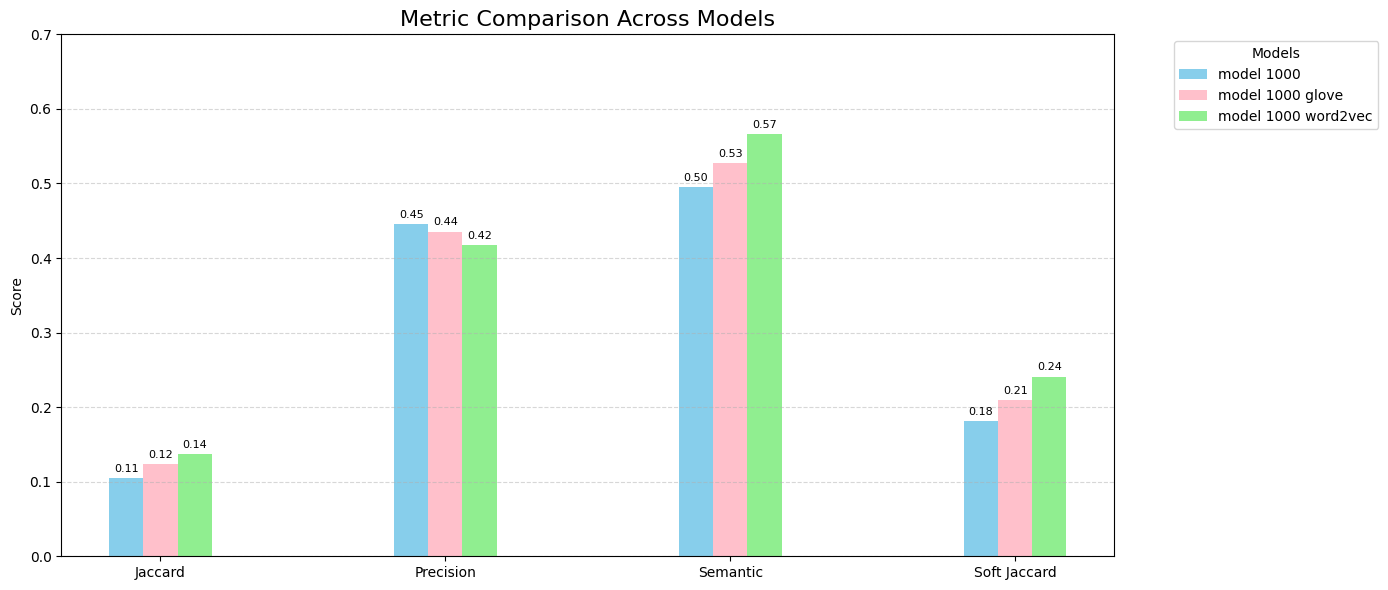

In [0]:
comparison_plot_metrics(models_name[:3],jaccard_scores[:3], precision_scores[:3], semantic_scores[:3], soft_jaccard_scores[:3],"1000")

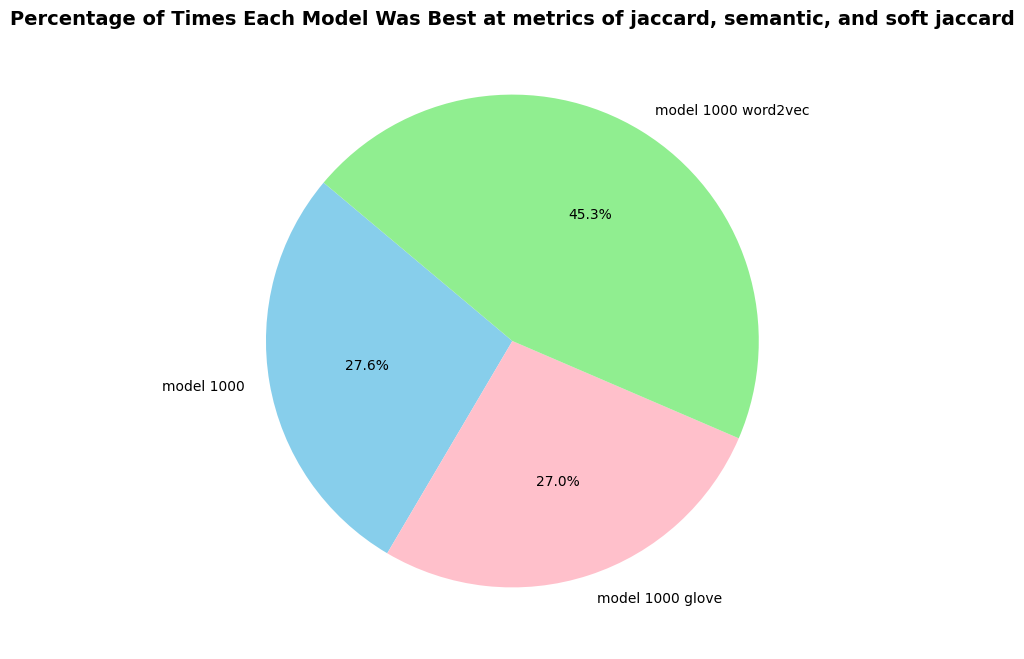

In [0]:
# usage of 1000 only
plot_model_win_percentages(metrics_1000_list, models_name[:3],"1000")

In [0]:
rank_scores_1000 = rank_based_score(metrics_1000_list, models_name[:3])

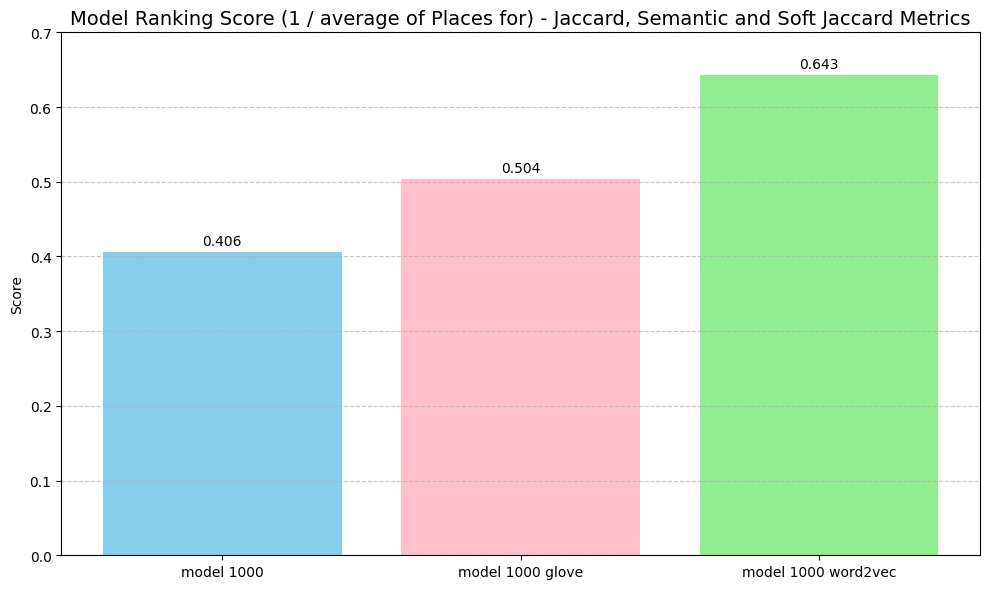

In [0]:
plot_rank_scores(rank_scores_1000,"1000")

#### Embedding models comparison

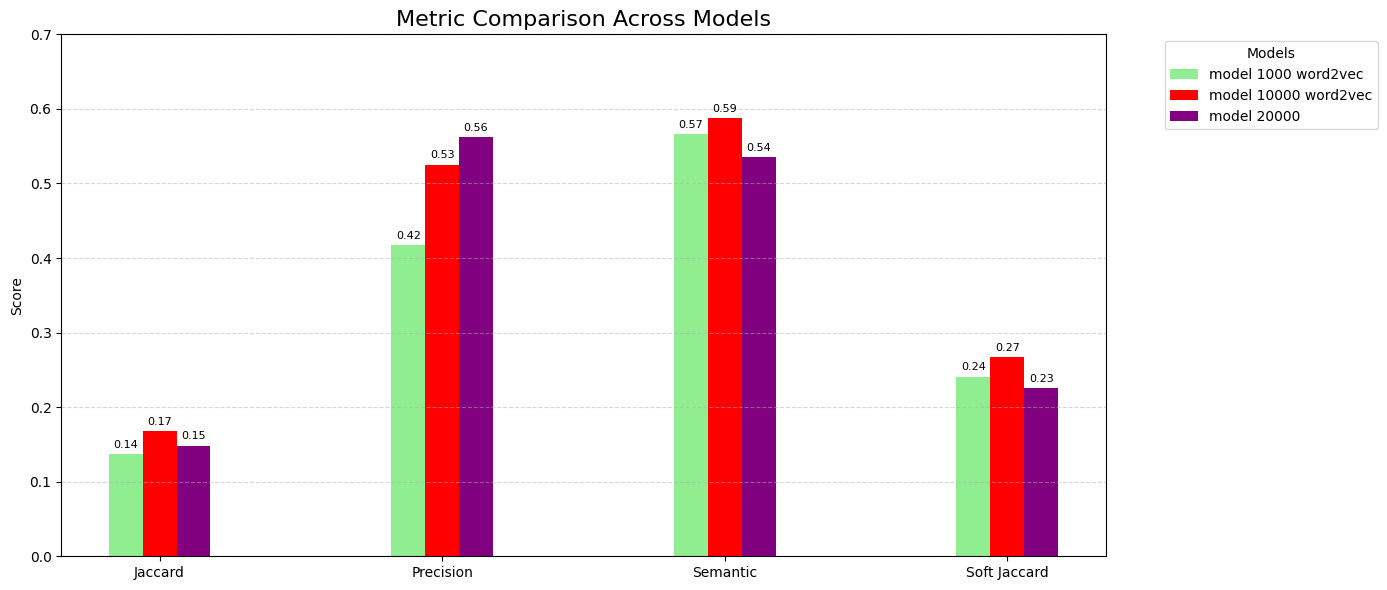

In [0]:
comparison_plot_metrics(models_name[2:],jaccard_scores[2:], precision_scores[2:], semantic_scores[2:], soft_jaccard_scores[2:],"word2vec")

In [0]:
rank_scores_embedding = rank_based_score(metrics_embedding_list, models_name[2:])

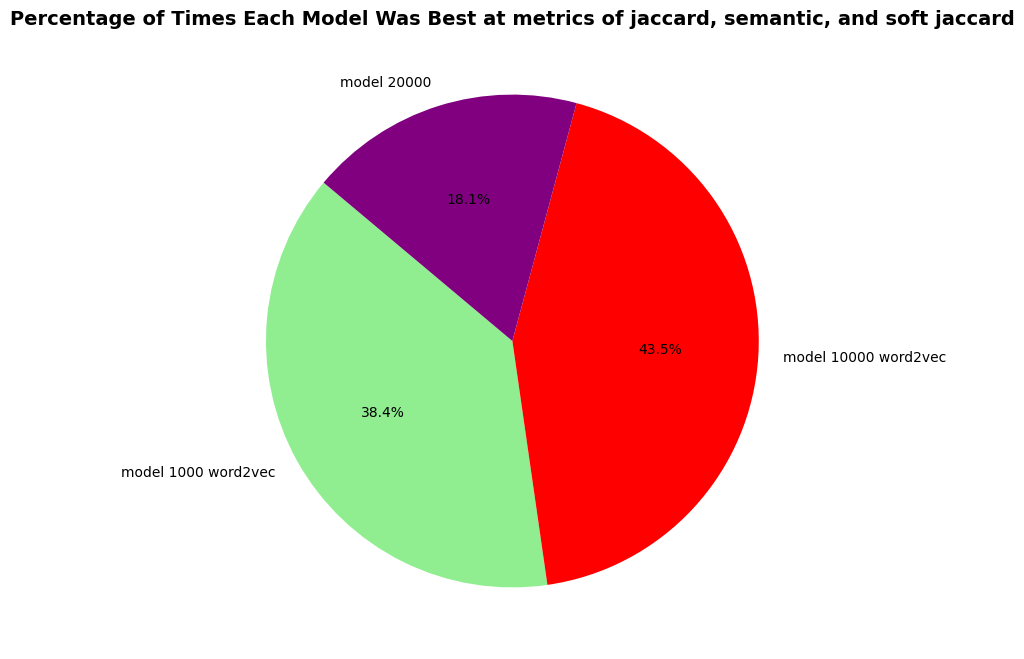

In [0]:
# usage of 1000 only
plot_model_win_percentages(metrics_embedding_list, models_name[2:],"word2vec")

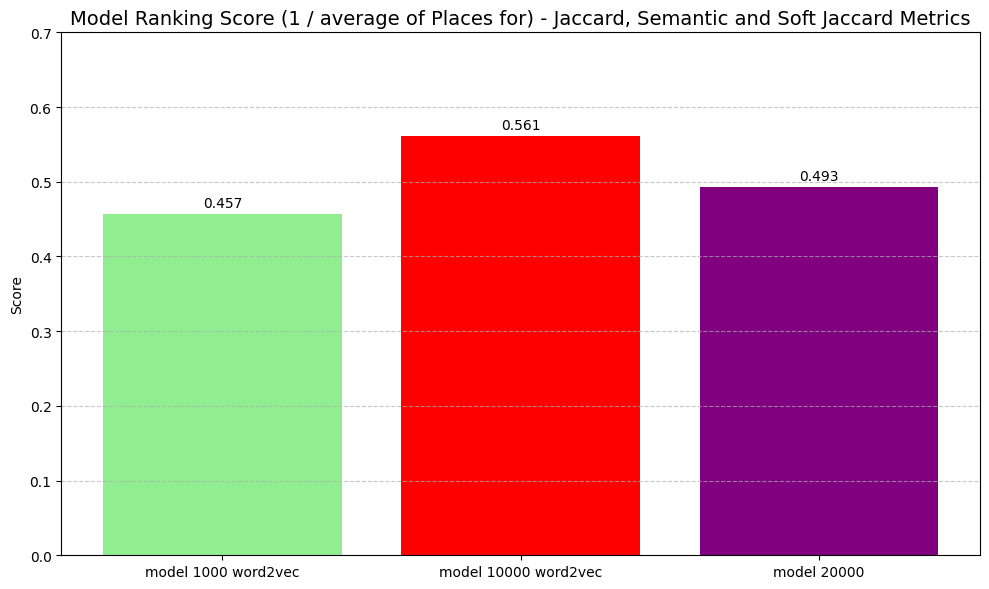

In [0]:
plot_rank_scores(rank_scores_embedding,"word2vec")

Try to merge some of the of the models to examine if it gives better results 

In [0]:
def merge_model_predictions(model1_preds, model2_preds):
    merged_preds = [model1 | model2 for model1, model2 in zip(model1_preds, model2_preds)]
    return [set(pred) for pred in merged_preds]  # Ensure final output is a list of sets

In [0]:
 skills_pred_20000_10000_w2v = merge_model_predictions(skills_pred_20000, skills_pred_10000_word2vec)  # Union of Model 1 and Model 2
 skills_pred_20000_10000_w2v_glassdoor = merge_model_predictions(skills_pred_20000_10000_w2v, skills_pred_10000_glassdoor)  # Union of Model 1-2 and Model 3

In [0]:
# all evaluations for model trained with 10000 rows word2vec, 20000 rows, and 10000 word2vec + finetune Glassdoor
jaccard_precision_union = jaccard_precision_score(validate_df, skills_pred_20000_10000_w2v_glassdoor,"model 20000, 10000 word2vec, glassdoor")
semantic_score_union = semantic_similarity_score(validate_df, skills_pred_20000_10000_w2v_glassdoor, minilm_model,"model 20000, 10000 word2vec, glassdoor")
soft_score_union = soft_jaccard_score(validate_df, skills_pred_20000_10000_w2v_glassdoor,word2vec_model,"model 20000, 10000 word2vec, glassdoor")


 Evaluation Metrics of model 20000, 10000 word2vec, glassdoor:
 Jaccard Similarity Score: 0.1791
 Precision: 0.5055
 Recall:    0.2212
 F1 Score:  0.2845

 Semantic Evaluation of model 20000, 10000 word2vec, glassdoor:
 Average Cosine Similarity: 0.6067

 Soft Jaccard (word2vec) for model 20000, 10000 word2vec, glassdoor: 0.2926


In [0]:
jaccard_scores += [jaccard_precision_union[1]]
precision_scores += [jaccard_precision_union[2]]                 
semantic_scores += [semantic_score_union[1]]
soft_jaccard_scores += [soft_score_union[1]]

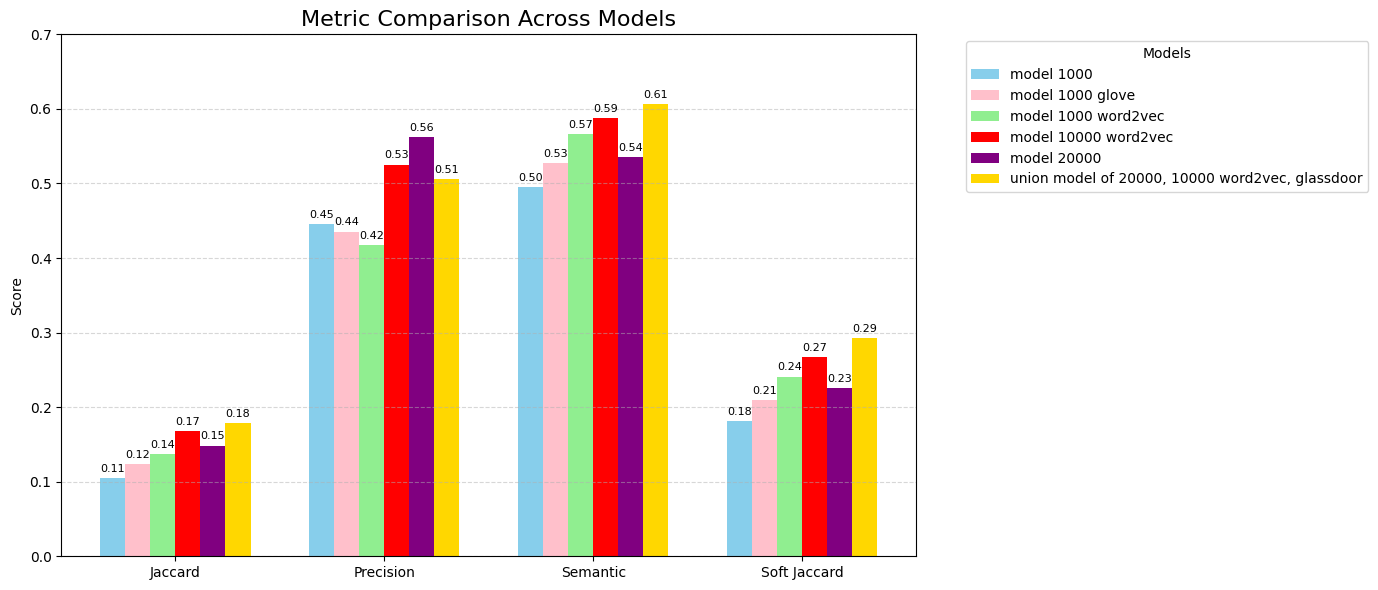

In [0]:
comparison_plot_metrics(models_name+["union model of 20000, 10000 word2vec, glassdoor"],jaccard_scores, precision_scores, semantic_scores, soft_jaccard_scores, "all")

#### After the model improvements, we test our model on the test set

In [0]:
skills_pred_10000_word2vec_test = []
skills_pred_10000_glassdoor_test = []
skills_pred_20000_test = []


for job in test_list:

    doc_20000_test = nlp_ner_20000(job[1])
    doc_10000_word2vec_test = nlp_ner_10000_word2vec(job[1])
    doc_10000_glassdoor_test = nlp_ner_10000_glassdoor(job[1])

    skills_extracted_20000_test = [ent.text for ent in doc_20000_test.ents if ent.label_ == "SKILL"]
    skills_extracted_10000_word2vec_test = [ent.text for ent in doc_10000_word2vec_test.ents if ent.label_ == "SKILL"]
    skills_extracted_10000_glassdoor_test = [ent.text for ent in doc_10000_glassdoor_test.ents if ent.label_ == "SKILL"]

    skills_pred_10000_glassdoor_test.append(set(skills_extracted_10000_glassdoor_test))
    skills_pred_10000_word2vec_test.append(set(skills_extracted_10000_word2vec_test))
    skills_pred_20000_test.append(set(skills_extracted_20000_test))

In [0]:
skills_pred_20000_10000_w2v_test = merge_model_predictions(skills_pred_20000_test, skills_pred_10000_word2vec_test)  # Union of Model 1 and Model 2
skills_pred_20000_10000_w2v_glassdoor_test = merge_model_predictions(skills_pred_20000_10000_w2v_test, skills_pred_10000_glassdoor_test)  # Union of Model 1-2 and Model 3

In [0]:
# all evaluations for model trained with 10000 rows word2vec, 20000 rows, and 10000 word2vec + finetune Glassdoor
jaccard_precision_union_test = jaccard_precision_score(test_df, skills_pred_20000_10000_w2v_glassdoor_test,"model 20000, 10000 word2vec, glassdoor")
semantic_score_union_test = semantic_similarity_score(test_df, skills_pred_20000_10000_w2v_glassdoor_test, minilm_model,"model 20000, 10000 word2vec, glassdoor")
soft_score_union_test = soft_jaccard_score(test_df, skills_pred_20000_10000_w2v_glassdoor_test,word2vec_model,"model 20000, 10000 word2vec, glassdoor")


 Evaluation Metrics of model 20000, 10000 word2vec, glassdoor:
 Jaccard Similarity Score: 0.1752
 Precision: 0.5039
 Recall:    0.2167
 F1 Score:  0.2800

 Semantic Evaluation of model 20000, 10000 word2vec, glassdoor:
 Average Cosine Similarity: 0.6115

 Soft Jaccard (word2vec) for model 20000, 10000 word2vec, glassdoor: 0.2897
